In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!git clone https://github.com/saisriteja/audio_visual_work

Cloning into 'audio_visual_work'...
remote: Enumerating objects: 627, done.
remote: Counting objects: 100% (627/627), done.
remote: Compressing objects: 100% (625/625), done.
remote: Total 1483 (delta 4), reused 595 (delta 0), pack-reused 856
Receiving objects: 100% (1483/1483), 304.15 MiB | 25.35 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (982/982), done.


In [ ]:
ls

__notebook__.ipynb  audio_visual_work/


In [ ]:
import os
# os.getcwd()

current_dir = os.getcwd()

In [ ]:
current_dir

'/kaggle/working'

In [ ]:
# %tensorflow_version 1.x

from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Conv2D, Activation, add, Reshape, Bidirectional
from keras.layers import Dropout, Input, BatchNormalization, Concatenate
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
from keras.models import Sequential
from keras import optimizers
from keras.metrics import categorical_accuracy
from glob import glob
from keras.utils import to_categorical
import numpy as np
from keras.utils import np_utils
import os
import cv2
import pickle
from random import shuffle
init_notebook_mode(connected=True)

In [ ]:
def get_category(f):
    # print(f)
        
    if f[0] == 'a':
        return(0)
        
    elif f[0] == 'd':
        return(1)
        
    elif f[0] == 'n':
        return(2)
        
    elif f[0] == 'h':
        return(3)
    
    elif f[0] == 'f':
        return(4)
        
    elif f[0:2] == 'su':
        return(5)
        
    elif f[0:2] == 'sa':
        return(6)

def load_obj(name ):
    # print(name)
    with open(name , 'rb') as f:
        return pickle.load(f)

# files = glob('/content/audio_visual_work/data_video/DC*')

def get_train_test_val(person):
    f = {'a':[],
        'd':[],
        'sa':[],
        'su':[],
        'n':[],
        'h':[],
        'f':[]}

    # for i in list(f.keys()):
      #  print(glob(f'/content/audio_visual_work/data_video/DC_{i}*'))
      # f[i] = glob(f'/content/audio_visual_work/data_video/{person}_{i}*')
    for i in list(f.keys()):
        if i != 'n':
            f[i] = [f'/kaggle/working/audio_visual_work/data_video/{person}_{i}{no+1}' for no in range(15)]
        if i == 'n':
            f[i] = [f'/kaggle/working/audio_visual_work/data_video/{person}_{i}{no+1}' for no in range(30)]


    train = []
    test = []
    val = []


    for i in list(f.keys()):
      
      shuffle(f[i])

      # print('emotion',i,'elements',len(f[i]))

      # print(-0+int(0.7*(len(f[i]))) - int(0.7*(len(f[i])))+int(0.8*(len(f[i]))) -int(0.8*(len(f[i])))+int(1*(len(f[i]))))

      train.extend(f[i][0:int(0.7*(len(f[i])))])
      val.extend(f[i][int(0.7*(len(f[i]))):int(0.8*(len(f[i])))])
      test.extend(f[i][int(0.8*(len(f[i]))):])

      # print(len(train),len(test),len(val))

    return (sorted(set(train)),sorted(set(test)),sorted(set(val)))

In [ ]:
train,test,val = [],[],[]

for p in ['DC','KL','JE','JK']:
    a,b,c = get_train_test_val(p)
    train.extend(a)
    test.extend(b)
    val.extend(c)
    # break

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
import random

In [ ]:

facial_path = '/kaggle/working/audio_visual_work/data_video'
audio_path = '/kaggle/working/audio_visual_work/data_audio'



def agumentation_process(aug_type_no,img):
    # the input should be a numpy array of a single 3 channel image

    # 1 for flip
    # 2 for rotate
    # 3 for gaussian noise
    # 4 for contrast
    # 5 for shearing


    if aug_type_no == 1:
      flip_hr=iaa.Fliplr(p=1.0)
      flip_hr_image= flip_hr.augment_image(img)

      return flip_hr_image


    if aug_type_no == 2:

      n1 = random.randint(-50,50)
      n2 = random.randint(-30,30)

      rotate=iaa.Affine(rotate=(n1, n2))
      rotated_image=rotate.augment_image(img)
      return rotated_image

    if aug_type_no == 3:
            
      n1 = random.randint(0,10)
      n2 = random.randint(0,20)

      gaussian_noise=iaa.AdditiveGaussianNoise(n1,n2)
      noise_image=gaussian_noise.augment_image(img)

      return noise_image
    
    if aug_type_no == 4:
      
      n1 = random.randint(0,4)
      contrast=iaa.GammaContrast(gamma=n1)
      contrast_image =contrast.augment_image(img)
      return contrast_image

    if aug_type_no == 5:

      n1 = random.randint(10,40)

      shear = iaa.Affine(shear=(0,n1))
      shear_image=shear.augment_image(img)
      return shear_image






def data_generator(files, batch_size = 8,agumentation = False):
    while(True):
        batch_paths  = np.random.choice(a = files, size = batch_size)

        batch_facial  = []
        batch_audio = []
        batch_output = [] 

        for filename in batch_paths:

            # print(filename)

            cat = get_category(filename.split('_')[-1])

            ff = load_obj(os.path.join(facial_path,filename))

            b_f = np.array(ff)


            if agumentation:
                
                    # 1 for flip
                    # 2 for rotate
                    # 3 for gaussian noise
                    # 4 for contrast
                    # 5 for shearing

              #select a random number for agumentation type
              foo = [1,3,4]
    
              aug_no  = random.choice(foo)

              for no,vid in enumerate(b_f):
                b_f[no] = agumentation_process(aug_no,vid) 
            
            b_f = b_f/255

            batch_facial.append(b_f)

            batch_output.append(cat)

        # batch_facial = np.expand_dims(batch_facial,axis = 0)
        batch_facial = np.array(batch_facial)


        batch_output = np.array(batch_output)

        yield (batch_facial.astype('float32'),np_utils.to_categorical(batch_output,num_classes=7))



In [ ]:
train_generator = data_generator(train,batch_size=8,agumentation= True)
val_generator = data_generator(val,batch_size=8, agumentation= True)
x,y = next(train_generator)
x.shape

(8, 96, 64, 64, 3)

In [ ]:

def get_model():

    ## input layer
    input_layer = Input((96, 64,64, 3))

    ## convolutional layers
    conv_layer1 = Conv3D(filters=32, kernel_size=(15, 3, 3), activation='relu')(input_layer)
    pooling_layer2 = MaxPool3D(pool_size=(3,3,3))(conv_layer1)
    dropout = Dropout(0.4)(pooling_layer2)
    flatten_layer = Flatten()(dropout)


    dense_layer1 = Dense(units=128, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)

    output_layer = Dense(units=7, activation='softmax')(dense_layer1)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model = get_model()


In [ ]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=30, monitor="val_loss",min_delta=0.0001,verbose = 1),
    keras.callbacks.ModelCheckpoint(filepath='model.h5',verbose = 1,save_best_only=True),
    # keras.callbacks.TensorBoard(log_dir='./logs'),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=20,cooldown = 1,verbose = 1)
]
model = get_model()
model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(lr=1e-4,momentum = 0.9),metrics=['acc'])


batch_size = 8
history = model.fit_generator(train_generator,
                              steps_per_epoch=int(len(train)/batch_size),
                              epochs=300,
                              validation_data= val_generator,
                              validation_steps=len(val)//batch_size,
                              callbacks = my_callbacks)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/300
40/40 [==============================] - 25s 540ms/step - loss: 1.9552 - acc: 0.2452 - val_loss: 1.9451 - val_acc: 0.2143

Epoch 00001: val_loss improved from inf to 1.94506, saving model to model.h5
Epoch 2/300
40/40 [==============================] - 20s 508ms/step - loss: 1.9713 - acc: 0.2576 - val_loss: 1.9036 - val_acc: 0.2500

Epoch 00002: val_loss improved from 1.94506 to 1.90362, saving model to model.h5
Epoch 3/300
40/40 [==============================] - 21s 527ms/step - loss: 1.9197 - acc: 0.2168 - val_loss: 1.9145 - val_acc: 0.2500

Epoch 00003: val_loss did not improve from 1.90362
Epoch 4/300
40/40 [==============================] - 20s 511ms/step - loss: 1.9131 - acc: 0.2603 - val_loss: 1.9256 - val_acc: 0.1964

Epoch 00004: val_loss did not improve from 1.90362
Epoch 5/300
40/40 [==============================] - 20s 515ms/step - loss: 1.9170 - acc: 0.1893 - val_loss: 1.9225 - val_acc: 0.1964

Epoch 00005: val_loss did not improve from 1.90362
Epoch 6/300
40

In [ ]:
def load_obj(name ):
    # print(name)
    with open(name , 'rb') as f:
        return pickle.load(f)

def data_generator(files, batch_size = 8):
    while(True):
        # batch_paths  = np.random.choice(a = files, size = batch_size)
        batch_paths = files

        batch_facial  = []
        batch_audio = []
        batch_output = [] 

        for filename in batch_paths:

            # print(filename)

            cat = get_category(filename.split('_')[-1])

            batch_facial.append(load_obj(os.path.join(facial_path,filename)))


            b_f = np.array(batch_facial)/255.0
            # b_v = np.array(batch_audio)/255.0
            batch_output.append(cat)

        batch_output = np.array(batch_output)

        yield (b_f.astype('float32'),np_utils.to_categorical(batch_output,num_classes=7))


test_inp,test_out = next(data_generator(test))

# model.predict()

In [ ]:
test_inp.shape

(96, 96, 64, 64, 3)

In [ ]:
predicted = model.predict(test_inp)

y_pred = [np.argmax(i) for i in predicted]
y_true = [np.argmax(i) for i in test_out]



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[12,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  0,  0,  0,  1,  0],
       [ 0,  0, 24,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0],
       [ 0,  0,  0,  0, 12,  0,  0],
       [ 0,  0,  0,  0,  0, 12,  0],
       [ 0,  1,  0,  0,  1,  0, 10]])

In [ ]:
(confusion_matrix(y_true, y_pred,normalize='true')*100).astype('int')

array([[100,   0,   0,   0,   0,   0,   0],
       [  0,  91,   0,   0,   0,   8,   0],
       [  0,   0, 100,   0,   0,   0,   0],
       [  0,   0,   0, 100,   0,   0,   0],
       [  0,   0,   0,   0, 100,   0,   0],
       [  0,   0,   0,   0,   0, 100,   0],
       [  0,   8,   0,   0,   8,   0,  83]])

In [ ]:
target_names = 'a d n h f su sa'.split(' ')

<AxesSubplot:>

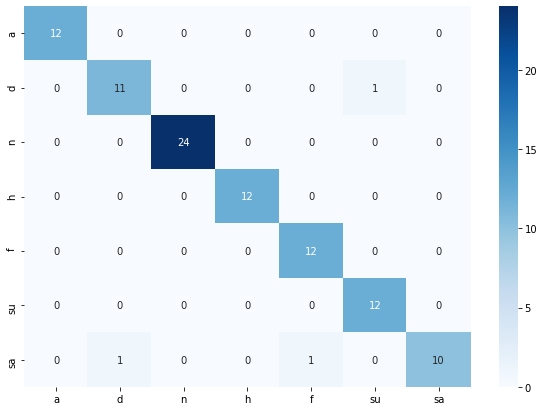

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='Blues')

<AxesSubplot:>

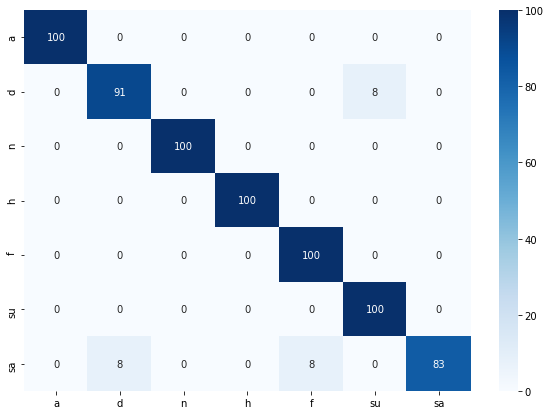

In [ ]:
df_cm = pd.DataFrame((confusion_matrix(y_true, y_pred,normalize='true')*100).astype('int')
, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g',cmap= 'Blues')

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00        12
           d       0.92      0.92      0.92        12
           n       1.00      1.00      1.00        24
           h       1.00      1.00      1.00        12
           f       0.92      1.00      0.96        12
          su       0.92      1.00      0.96        12
          sa       1.00      0.83      0.91        12

    accuracy                           0.97        96
   macro avg       0.97      0.96      0.96        96
weighted avg       0.97      0.97      0.97        96



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.96875

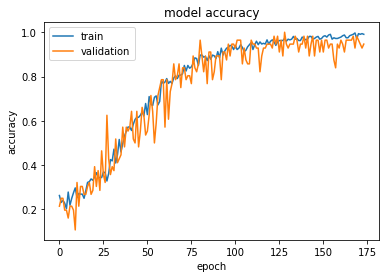

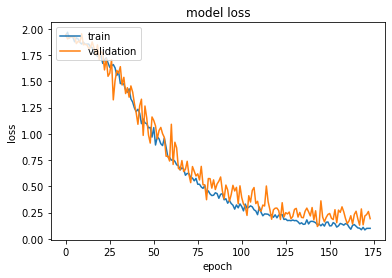

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pickle
filename = 'filenames.pkl'
outfile = open(filename,'wb')

pickle.dump([train,test,val],outfile)
outfile.close()